In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

## Make Toy data

In [3]:
x_train = np.linspace(0, 40, 10000, dtype = np.float32) + np.random.rand(10000).astype(np.float32)
y_train = 2*np.linspace(0, 40, 10000) + 3

x_test = np.linspace(0, 100, 1000, dtype = np.float32)
y_test = 2*x_test + 3

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).cache().prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(1).cache().prefetch(1)

In [5]:
x, y = next(iter(train_ds))
x.shape

TensorShape([32])

## Simple NN

In [2]:
model = keras.Sequential([
    keras.layers.Dense(1)
])

model.build(input_shape = (1, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics=['mse'],
)

model.fit(train_ds, validation_data = test_ds, epochs = 50)

Epoch 1/50
313/313 [==============================] - 2s 6ms/step - loss: 1236.7874 - mse: 1236.7874 - val_loss: 5746.4092 - val_mse: 5746.4092
Epoch 2/50
313/313 [==============================] - 2s 5ms/step - loss: 802.0059 - mse: 802.0059 - val_loss: 3884.5120 - val_mse: 3884.5120
Epoch 3/50
313/313 [==============================] - 1s 4ms/step - loss: 534.2526 - mse: 534.2526 - val_loss: 2563.0305 - val_mse: 2563.0305
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 343.6884 - mse: 343.6884 - val_loss: 1623.6914 - val_mse: 1623.6914
Epoch 5/50
313/313 [==============================] - 1s 5ms/step - loss: 210.5184 - mse: 210.5184 - val_loss: 975.8702 - val_mse: 975.8702
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 121.1749 - mse: 121.1749 - val_loss: 549.7145 - val_mse: 549.7145
Epoch 7/50
313/313 [==============================] - 2s 5ms/step - loss: 64.5929 - mse: 64.5929 - val_loss: 286.5266 - val_mse: 286.5266
Epoch 8/50
3

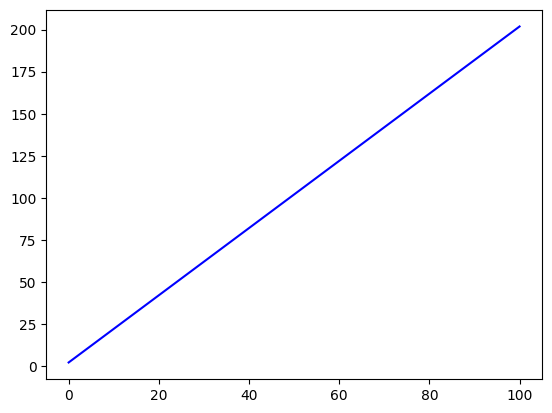

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x_test, model(x_test), 'b-')

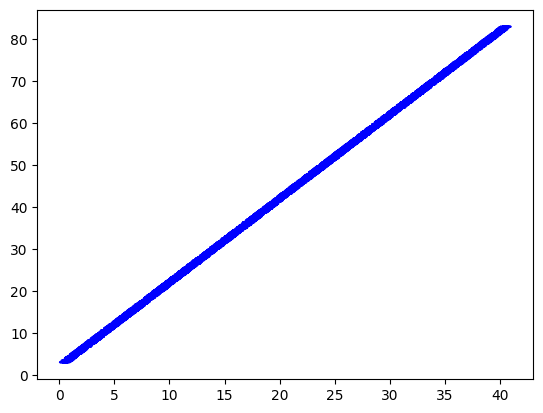

In [ ]:
plt.plot(x_train, y_train, 'b-')

In [ ]:
model(np.array([50]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[101.98176]], dtype=float32)>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_quant = converter.convert()

In [6]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
        # Model has only one input so each data point has one element
        yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant2 = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint 8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant3 = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [8]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_quant_file = tflite_models_dir/"lr.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

1092

In [ ]:
tflite_model_quant_file2 = tflite_models_dir/"lr_io32fp.tflite"
tflite_model_quant_file2.write_bytes(tflite_model_quant2)

1592

In [9]:
# Save the using integer-only quantization:
tflite_model_quant_file3 = tflite_models_dir/"lr_io8int.tflite"
tflite_model_quant_file3.write_bytes(tflite_model_quant3)

1464

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global x_test

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), ), dtype = int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = np.array([x_test[test_image_index]])
        # Check if the input type is quantized, the rescale input data to to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details['quantization']
            test_image = test_image/input_scale + input_zero_point
        test_image = np.expand_dims(test_image, axis = 0).astype(input_details['dtype'])
        interpreter.set_tensor(input_details['index'], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])[0]

        predictions[i] = output

    return predictions

def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  loss = np.sum(np.abs(predictions - y_test)) / len(x_test)

  print('%s model loss is %.4f (Number of test samples=%d)' % (
      model_type, loss, len(x_test)))

In [ ]:
x_test = np.linspace(0, 100, 1000, dtype = np.float32)
y_test = 2*x_test+3

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="IO Float")

IO Float model loss is 1.5000 (Number of test samples=1000)


<ipython-input-24-729a82032982>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i] = output


In [ ]:
evaluate_model(tflite_model_quant_file2, model_type="IO Float")

IO Float model loss is 82.9500 (Number of test samples=1000)


<ipython-input-24-729a82032982>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i] = output


In [ ]:
evaluate_model(tflite_model_quant_file3, model_type="IO Float")

IO Float model loss is 75.2152 (Number of test samples=1000)


<ipython-input-24-729a82032982>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i] = output


In [ ]:
interpreter = tf.lite.Interpreter(model_path = str(tflite_model_quant_file3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_dense_1_input:0',
 'index': 0,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([-1,  1], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.03886239230632782, 0),
 'quantization_parameters': {'scales': array([0.03886239], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [11]:
import shutil
#shutil.copy2(tflite_model_quant_file2, '/content')
shutil.copy2(tflite_model_quant_file3, '/content')

'/content/lr_io8int.tflite'

In [ ]:
shutil.copy2(tflite_model_quant_file, '/content')

'/content/lr.tflite'

In [ ]:
!xxd /content/sin_io32fp.tflite >> sin_io32fp.cc

In [ ]:
!echo "const unsigned char model[] = {" > /content/lr_io32fp.h
!cat /content/lr_io32fp.tflite | xxd -i      >> /content/lr_io32fp.h
!echo "};"                              >> /content/lr_io32fp.h

import os
model_h_size = os.path.getsize("/content/lr_io32fp.tflite")
print(f"Header file, /content/lr_io32fp.tflite, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr_io32fp.tflite, is 1,592 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [12]:
!echo "const unsigned char model[] = {" > /content/lr_io8int.h
!cat /content/lr_io8int.tflite | xxd -i      >> /content/lr_io8int.h
!echo "};"                              >> /content/lr_io8int.h

import os
model_h_size2 = os.path.getsize("/content/lr_io8int.tflite")
print(f"Header file, /content/lr_io8int.tflite, is {model_h_size2:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr_io8int.tflite, is 1,464 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
!echo "const unsigned char model[] = {" > /content/lr.h
!cat /content/lr.tflite | xxd -i      >> /content/lr.h
!echo "};"                              >> /content/lr.h

import os
model_h_size3 = os.path.getsize("/content/lr.tflite")
print(f"Header file, /content/lr.tflite, is {model_h_size3:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr.tflite, is 1,092 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
